In [1]:
from read_data.windsat_daily_v7 import WindSatDaily
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import RegularGridInterpolator

# 設置文件夾保存圖像
output_folder = "windSAT_images"
os.makedirs(output_folder, exist_ok=True)

In [7]:
# 設定範圍和條件
# 將日期定義為變量
date = "20201007"
dtype = "test_data"

# 定义经纬度范围
lon1, lon2 = 120, 130
lat1, lat2 = 10, 20

In [8]:
import numpy as np
# 讀取數據
dataset2 = WindSatDaily(f"{dtype}/wsat_{date}rt.gz")
# ascending or descending pass
path = 1 # descending pass

latitude2 = dataset2.variables['latitude'][:]  # 緯度
longitude2 = dataset2.variables['longitude'][:] # 經度
wind_aw = dataset2.variables['w-aw'][:][path]  
wind_lf = dataset2.variables['w-lf'][:][path]  
wind_mf = dataset2.variables['w-mf'][:][path]
wind_dir2 = dataset2.variables['wdir'][:][path]
rain_flag = dataset2.variables['rain'][:][path]  # 降水標誌

print("latitude shape",latitude2.shape)
print("longitude shape",longitude2.shape)
print("wind_speed shape",wind_lf.shape)
print("wind_dir shape",wind_dir2.shape)
print("rain_flag shape",rain_flag.shape)

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import RegularGridInterpolator

# 限制範圍：110°E - 190°E, 0°N - 40°N
lon_min2, lon_max2 = 110, 190
lat_min2, lat_max2 = 0, 40

lon_idx2 = (longitude2 >= 110) & (longitude2 <= 190)
lat_idx2 = (latitude2 >= lat_min2) & (latitude2 <= lat_max2)

longitude2_subset = longitude2[lon_idx2]
latitude2_subset = latitude2[lat_idx2]
wind_mf_subset = wind_mf[lat_idx2, :][:, lon_idx2]
wind_lf_subset = wind_lf[lat_idx2, :][:, lon_idx2]
wind_aw_subset = wind_aw[lat_idx2, :][:, lon_idx2]
wind_dir2_subset = wind_dir2[lat_idx2, :][:, lon_idx2]
rain_flag_subset = rain_flag[lat_idx2, :][:, lon_idx2]

# 設定範圍
lon_grid2_subset, lat_grid2_subset = np.meshgrid(longitude2_subset, latitude2_subset)

print('---after indexing---')
print("latitude_subset shape",latitude2_subset.shape)
print("longitude_subset shape",longitude2_subset.shape)
print("wind_lf_subset shape",wind_lf_subset.shape)
print("wind_mf_subset shape",wind_mf_subset.shape)
print("wind_aw_subset shape",wind_aw_subset.shape)
print("wind_dir_subset shape",wind_dir2_subset.shape)
print("rain_flag_subset shape",rain_flag_subset.shape)

latitude shape (720,)
longitude shape (1440,)
wind_speed shape (720, 1440)
wind_dir shape (720, 1440)
rain_flag shape (720, 1440)
---after indexing---
latitude_subset shape (160,)
longitude_subset shape (320,)
wind_lf_subset shape (160, 320)
wind_mf_subset shape (160, 320)
wind_aw_subset shape (160, 320)
wind_dir_subset shape (160, 320)
rain_flag_subset shape (160, 320)


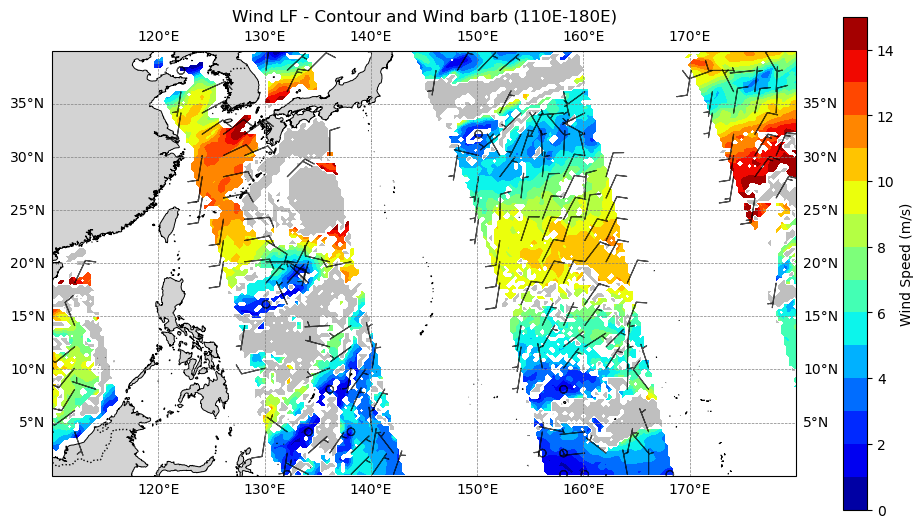

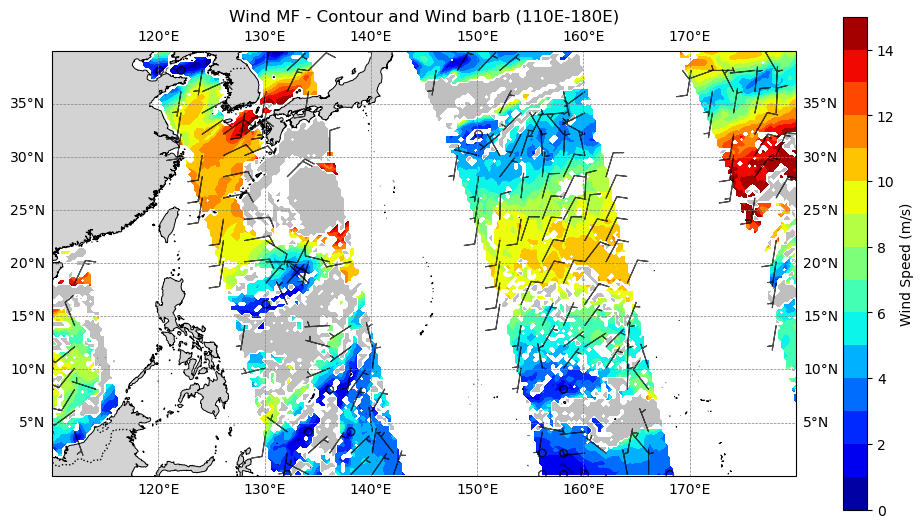

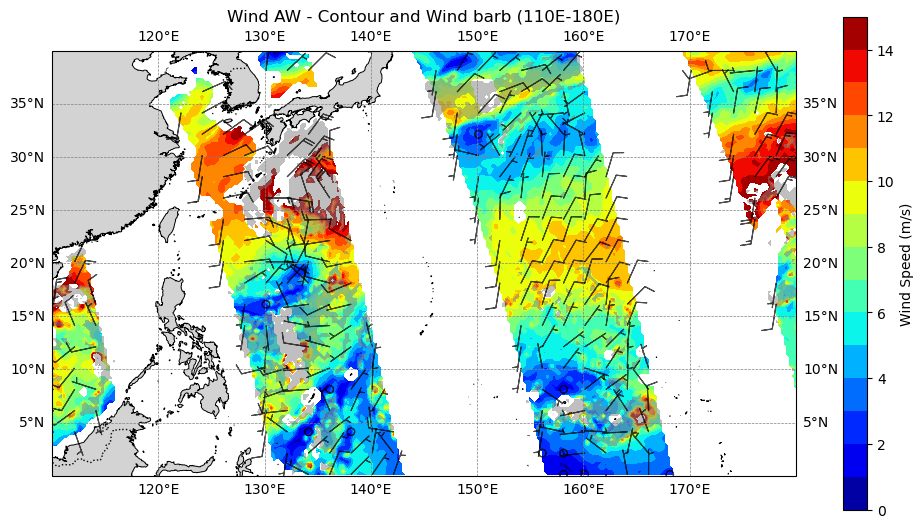

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

# 繪製函數
def plot_wind_contour_and_arrows_with_map(lon, lat, wind_speed, wind_dir2, rain_flag, title):
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())  # 設置地圖投影
    
    # 限制地圖範圍到 110E - 190E
    ax.set_extent([110, 180, 0, 40], crs=ccrs.PlateCarree())

    # 添加地圖背景
    ax.coastlines(resolution='10m', color='black', linewidth=0.7)  # 繪製海岸線
    ax.add_feature(cfeature.BORDERS, linestyle=':')  # 添加國家邊界
    ax.add_feature(cfeature.LAND, facecolor='lightgray')  # 填充陸地顏色
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')  # 繪製經緯度網格

    mask = ~np.isnan(wind_speed) & (wind_speed > 0)  # 非 NaN 且風速 > 0
    lon_filtered = np.where(mask, lon, np.nan)
    lat_filtered = np.where(mask, lat, np.nan)
    wind_speed_filtered = np.where(mask, wind_speed, np.nan)

    # 繪製風速等高線 (僅顯示非降水區域)
    contour = ax.contourf(
        lon_filtered, lat_filtered, wind_speed_filtered,
        levels=np.arange(0, 16, 1), cmap='jet', transform=ccrs.PlateCarree()
    )

    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, shrink=0.8)
    cbar.set_label("Wind Speed (m/s)")



    wind_speed_clipped = np.clip(wind_speed, 0, 50)  # 限制風速最大值為 50 m/s
    # # 填充降水區域 (rain_flag==1)
    # 假設 rain_flag 是您的數據
    rain_mask = np.where((rain_flag_subset > 0) & (rain_flag_subset <= 25), rain_flag_subset, np.nan)
    ax.contourf(
         lon, lat, rain_mask,
         levels=[0,25],colors='gray', alpha=0.5, transform=ccrs.PlateCarree()
     )
    
    # 將風速與風向轉換為 U 和 V 分量
    u = wind_speed * np.cos(np.radians(wind_dir2))  # 計算U分量
    v = wind_speed * np.sin(np.radians(wind_dir2))  # 計算V分量
    
    # 過濾無效數據（僅保留有風速的區域）
    mask = ~np.isnan(wind_speed) & (wind_speed > 0)  # 非 NaN 且風速 > 0
    u_filtered = np.where(mask, u, np.nan)
    v_filtered = np.where(mask, v, np.nan)
    lon_filtered = np.where(mask, lon, np.nan)
    lat_filtered = np.where(mask, lat, np.nan)
    
    # 繪製風標 (僅繪製有效數據區域)
    skip = (slice(None, None, 8), slice(None, None, 8))  # 每隔10個點繪製
    ax.barbs(
        lon_filtered[skip], lat_filtered[skip],
        u_filtered[skip], v_filtered[skip],
        length=6, color='black', linewidth=0.8, alpha=0.7, transform=ccrs.PlateCarree()
    )
    
    
    # 添加標題
    plt.title(title)
    plt.show()

# 繪製風速等高線圖與箭頭圖 (僅限 110E - 190E)
plot_wind_contour_and_arrows_with_map(
    lon_grid2_subset, lat_grid2_subset, wind_lf_subset, wind_dir2_subset, rain_flag_subset,
    'Wind LF - Contour and Wind barb (110E-180E)'
)

plot_wind_contour_and_arrows_with_map(
    lon_grid2_subset, lat_grid2_subset, wind_mf_subset, wind_dir2_subset, rain_flag_subset,
    'Wind MF - Contour and Wind barb (110E-180E)'
)
plot_wind_contour_and_arrows_with_map(
    lon_grid2_subset, lat_grid2_subset, wind_aw_subset, wind_dir2_subset, rain_flag_subset,
    'Wind AW - Contour and Wind barb (110E-180E)'
)